In [0]:
import librosa
import os
import random
import numpy as np
import csv
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/My\ Drive/accent
os.chdir('/content/gdrive/My Drive/accent')

arabic_mfcc13.csv  english_mfcc13.csv  Result_CNN_ERR.png   spanish_mfcc39.csv
arabic_mfcc39.csv  english_mfcc39.csv  Result_CNN_LOSS.png
cnn_model.ipynb    lstm_model.ipynb    spanish_mfcc13.csv


In [0]:
#feature extraction

def mfcc_feature(folder):

    num_data=180

    mfcc_array=[]
    label_array=[]

    for filename in os.listdir(folder):

        (rate,sig)=wav.read(folder+'/'+filename)
        
        float_sig=np.array(sig,dtype=float)
        
        normed_sig = librosa.util.fix_length(float_sig, 240000)
        normed_sig = (normed_sig - np.mean(normed_sig))/np.std(normed_sig)

        #mfcc=librosa.feature.mfcc(y=normed_sig, sr=rate, n_fft=512, hop_length=256, n_mfcc=13) #32ms #16ms #13d
        mfcc=librosa.feature.mfcc(y=normed_sig, sr=rate,n_fft=512, hop_length=256, n_mfcc=39) #39d
        #mfcc=librosa.feature.mfcc(y=normed_sig, sr=rate,n_fft=512, hop_length=256, n_mfcc=39, htk=True) #32ms #16ms #htk style
        mfcc=mfcc.reshape(mfcc.shape[1],mfcc.shape[0])
        mfcc_array.append(mfcc)

        if folder.endswith("arabic"):
            label=np.zeros((938,1),dtype=int)
            label_array.append(label)
        elif folder.endswith("english"):
            label=np.ones((938,1),dtype=int)
            label_array.append(label)
        elif folder.endswith("spanish"):
            label=np.ones((938,1),dtype=int)*2
            label_array.append(label)
        
    mfcc_array=np.array(mfcc_array)
    mfcc_array=mfcc_array.reshape(mfcc_array.shape[1]*num_data,mfcc_array.shape[2])
    print("mfcc shape:",mfcc_array.shape)

    label_array=np.array(label_array)
    label_array=label_array.reshape(label_array.shape[1]*num_data,label_array.shape[2])
    print("label shape:",label_array.shape)
    
    result=np.hstack((mfcc_array,label_array))
    print("total shape:",result.shape)

    mfcc_folder='C:/git/download/Accented speech recognition/Accent-Classifier/data/speech accent archive/mfcc'

    if folder.endswith("arabic"):
        with open(mfcc_folder+'/'+"arabic_mfcc.csv", 'w') as arabic_csv:
            np.savetxt(arabic_csv, result, delimiter=",")
    elif folder.endswith("english"):
        with open(mfcc_folder+'/'+"english_mfcc.csv", 'w') as english_csv:
            np.savetxt(english_csv, result, delimiter=",")
    elif folder.endswith("spanish"):
        with open(mfcc_folder+'/'+"spanish_mfcc.csv", 'w') as spanish_csv:
            np.savetxt(spanish_csv, result, delimiter=",")
 
mfcc_feature('C:/git/download/Accented speech recognition/Accent-Classifier/data/speech accent archive/exp/arabic')
mfcc_feature('C:/git/download/Accented speech recognition/Accent-Classifier/data/speech accent archive/exp/english')  
mfcc_feature('C:/git/download/Accented speech recognition/Accent-Classifier/data/speech accent archive/exp/spanish')

In [0]:
def csv2data(arabic, english, spanish):
  arabic_data = np.loadtxt(arabic, delimiter = ",", dtype = np.int32)
  english_data = np.loadtxt(english, delimiter = ",", dtype = np.int32)
  spanish_data = np.loadtxt(spanish, delimiter = ",", dtype = np.int32)

  num=168840
  trin_num = num-(num//4) #126630
  test_num = num//4 #42210
  #print(trin_num, test_num)

  arabic_train = arabic_data[:trin_num,:]
  arabic_test = arabic_data[trin_num:trin_num+test_num,:]

  english_train = english_data[:trin_num,:]
  english_test = english_data[trin_num:trin_num+test_num,:]

  spanish_train = spanish_data[:trin_num,:]
  spanish_test = spanish_data[trin_num:trin_num+test_num,:]

  train_data = np.vstack([arabic_train,english_train,spanish_train])
  test_data = np.vstack([arabic_test,english_test,spanish_test])

  #print("train data shape:",train_data.shape)
  #print("test data shape:",test_data.shape)

  return train_data, test_data


In [0]:
class Accent_dataset(Dataset):
    def __init__(self, train = True, transform = None):
        
        self.train = train
 
        num_data   =  180
        num_train  =  135
        num_test   =  45

        self.train_data, self.test_data= csv2data('arabic_mfcc13.csv','english_mfcc13.csv','spanish_mfcc13.csv')

        self.y_train=[]
        self.y_test=[] 

        if self.train == True:
          self.x_train= self.train_data[:,:-1]

          arabic_label=np.zeros((num_train,1),dtype=int)
          self.y_train.append(arabic_label)

          english_label=np.ones((num_train,1),dtype=int)
          self.y_train.append(english_label)

          spanish_label=np.ones((num_train,1),dtype=int)*2
          self.y_train.append(spanish_label)

          self.y_train=np.array(self.y_train)
          self.y_train=self.y_train.reshape(num_train*3)

          self.x_train = self.x_train.reshape(num_train*3, 938, 13) 

          self.x_train = torch.cuda.FloatTensor(self.x_train)
          self.y_train = torch.cuda.LongTensor(self.y_train)

          print("=== Dataset Download Complete !!")
          print("X Shape:",self.x_train.shape)
          print("Y Shape:",self.y_train.shape) 

        else:
          self.x_test= self.test_data[:,:-1]

          arabic_label=np.zeros((num_test,1),dtype=int)
          self.y_test.append(arabic_label)

          english_label=np.ones((num_test,1),dtype=int)
          self.y_test.append(english_label)

          spanish_label=np.ones((num_test,1),dtype=int)*2
          self.y_test.append(spanish_label)

          self.y_test=np.array(self.y_test)
          self.y_test=self.y_test.reshape(num_test*3)

          self.x_test = self.x_test.reshape(num_test*3, 938, 13) 

          self.x_test = torch.cuda.FloatTensor(self.x_test)
          self.y_test = torch.cuda.LongTensor(self.y_test)
          
          print("=== Dataset Download Complete !!")
          print("X Shape:",self.x_test.shape)
          print("Y Shape:",self.y_test.shape)
        
    def __getitem__(self, index):
        if self.train:
            return self.x_train[index], self.y_train[index]
        else:
            return self.x_test[index], self.y_test[index]
    
    def __len__(self):
        if self.train:
            return len(self.x_train)
        else:
            return len(self.x_test)

In [7]:
train_dataset = Accent_dataset(train = True)
test_dataset = Accent_dataset(train = False)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

=== Dataset Download Complete !!
X Shape: torch.Size([405, 938, 13])
Y Shape: torch.Size([405])
=== Dataset Download Complete !!
X Shape: torch.Size([135, 938, 13])
Y Shape: torch.Size([135])


In [8]:
#device setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cuda


In [0]:
#parameters

num_epochs=500
learning_rate=0.0001
batch_size=64

In [0]:
#lstm model

class LSTM_model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,batch_first=True):
        super(LSTM_model,self).__init__()

        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_layers=num_layers

        self.lstm=nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True) #batch, seq_len, feature

        # Readout layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self,x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

lstm_model=LSTM_model(13,100,3,2).to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [0]:
for i in range(len(list(lstm_model.parameters()))):
    print(list(lstm_model.parameters())[i].size())

torch.Size([400, 13])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([3, 100])
torch.Size([3])


Training start
Epoch:    0/500 | train loss: 0.010909
Epoch:    0/500 | test loss: 1.095482
[Testset] ERR: 0.629630 | ACC: 0.370370 (50 / 135)

Epoch:   50/500 | train loss: 0.007391
Epoch:   50/500 | test loss: 1.101302
[Testset] ERR: 0.562963 | ACC: 0.437037 (59 / 135)

Epoch:  100/500 | train loss: 0.000655
Epoch:  100/500 | test loss: 1.868710
[Testset] ERR: 0.607407 | ACC: 0.392593 (53 / 135)

Epoch:  150/500 | train loss: 0.000160
Epoch:  150/500 | test loss: 2.249460
[Testset] ERR: 0.607407 | ACC: 0.392593 (53 / 135)

Epoch:  200/500 | train loss: 0.000074
Epoch:  200/500 | test loss: 2.576293
[Testset] ERR: 0.585185 | ACC: 0.414815 (56 / 135)

Epoch:  250/500 | train loss: 0.000042
Epoch:  250/500 | test loss: 2.814716
[Testset] ERR: 0.607407 | ACC: 0.392593 (53 / 135)

Epoch:  300/500 | train loss: 0.000078
Epoch:  300/500 | test loss: 2.523007
[Testset] ERR: 0.585185 | ACC: 0.414815 (56 / 135)

Epoch:  350/500 | train loss: 0.000024
Epoch:  350/500 | test loss: 2.836145
[Test

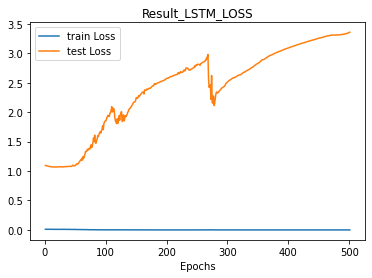

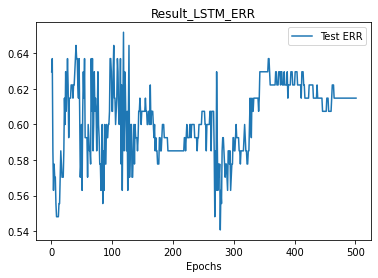

<Figure size 432x288 with 0 Axes>

In [12]:
print("Training start")

train_loss_list=[]
test_loss_list=[]

x_step=[]
y_err=[]

for epoch in range(num_epochs+1):
    for i, train_data in enumerate(train_loader):

      tain_loss = 0.0

      train_accent, train_label = train_data

      train_accent=train_accent.to(device)
      train_label=train_label.to(device)
      #print(train_accent, train_label)

      optimizer.zero_grad()

      hypothesis = lstm_model(train_accent).to(device)

      trn_loss = criterion(hypothesis, train_label)

      trn_loss.backward()
      optimizer.step()

      tain_loss+=trn_loss

      with torch.no_grad():

        test_loss=0.0
        correct = 0
        total = 0

        for j,test_data in enumerate(test_loader):

          test_accent, test_label = test_data

          test_accent=test_accent.to(device)
          test_label=test_label.to(device)
          #print(test_accent,test_label)

          prediction = lstm_model(test_accent).to(device)
          tst_loss = criterion(prediction, test_label)
          _, predicted = torch.max(prediction.data, 1)

          test_loss+=tst_loss*len(test_label)
          total += test_label.size(0)
          correct += (predicted == test_label).sum()

      correct = int(correct)
      total = int(total)

    if epoch % 50 ==0:
        print('Epoch: {:4d}/{} | train loss: {:.6f}'.format(epoch, num_epochs, tain_loss / 100))
        print("Epoch: {:4d}/{} | test loss: {:.6f}".format(epoch, num_epochs, test_loss / total))
        print('[Testset] ERR: %f | ACC: %f (%d / %d)' % (1 - (correct / total), correct / total, correct, total))
        print()

    train_loss_list.append(tain_loss/100)
    test_loss_list.append(test_loss/total)
    train_loss = 0.0

    x_step.append(epoch+1)
    y_err.append(1 - (correct / total))

plt.plot(x_step, train_loss_list, label = "train Loss")
plt.plot(x_step, test_loss_list, label = "test Loss")
plt.xlabel('Epochs')
plt.title('Result_LSTM_LOSS')
plt.legend()
plt.savefig('Result_LSTM_LOSS.png')
plt.show()
plt.clf()

plt.plot(x_step, y_err, label = "Test ERR")
plt.xlabel('Epochs')
plt.title('Result_LSTM_ERR')
plt.legend()
plt.savefig('Result_LSTM_ERR.png')
plt.show()
plt.clf()
